# A Quantitative Test for SARS-CoV-2 Infection

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

## Read and process original data file

In [42]:
ori_TPM = pd.read_csv("C:\\Users\\xuzef\\Desktop\\pycode\\final_proj\\TPM_S1G.txt", sep='\t', header=0, index_col=0)
gene_id = list(ori_TPM.index)
gene_symbol = ori_TPM.iloc[:,0].to_numpy().flatten()
ori_TPM = ori_TPM.drop(['Symbol'], axis=1)              # drop the 'Symbol' column, in which the genes are denoted using gene symbols (not standard)
all_TPM = ori_TPM.copy()                                # make a copy of this file for recovering purposes

names = list(all_TPM.columns)

# 8 healthy patients - unable to be split into 8:2 fraction - removed
remove = ["H1_H","H2_H","H3_H","H4_H","H6_H","H7_H","H8_H","H9_H"]

# special samples - may cause confusion - removed
special = ["43_D7A", "43_D7B", "87_D3A", "87_D3B", "154_D7A", "154_D7B", "302_DEA", "302_DEB", "321_D7A", "321_D7B"]
for n in names:
    if n in special:                               
        continue
    if "DE" in n:
        remove.append(n)                # DE samples - may cause confusion - removed                 
remove.extend(special)                  
all_TPM = all_TPM.drop(list(set(remove)), axis=1).T             # these special samples removed and shape from (n_genes, n_samples) to (n_samples, n_genes)
print(all_TPM.shape)                                            # 721 samples, 60640 features (genes)

(721, 60640)


## Calculate missing samples

In [43]:
missing = {}
all_samples = list(all_TPM.index)
for i in range(1,387):
    if i in [141,142,183,202,269,270]:              # these patients have no data available
        continue
    missing[i] = 0
    if f'{i}_D0' not in all_samples and len(f'{i}_D0')==3+len(str(i)):
        missing[i] += 1
    if f'{i}_D3' not in all_samples and len(f'{i}_D0')==3+len(str(i)):
        missing[i] += 1
    if f'{i}_D7' not in all_samples and len(f'{i}_D0')==3+len(str(i)):
        missing[i] += 1

have_1 = []             # ids of patients with only 1 timepoint data
have_2 = []             # ids of patients with only 2 timepoints data
have_3 = []             # ids of patients with full data (3 timepoints)
for k, v in missing.items():
    if v == 0:
        have_3.append(k)
    elif v == 1:
        have_2.append(k)
    else:
        have_1.append(k)                  

print(len(have_1))              # 160 patients - total 160*1 = 160 samples
print(len(have_2))              # 99 patients - total 99*2 = 198 samples
print(len(have_3))              # 121 patients - total 121*3 = 363 samples

160
99
121


## Read labels file

In [44]:
# all 1040 labels (as previous thought and imputed) but only need 721 of them now
labels_data = pd.read_csv("C:\\Users\\xuzef\\Desktop\\pycode\\final_proj\\data\\labels.csv", sep=',', encoding='UTF-8', header=0, index_col=0).loc[all_samples,:]
acuity_labels = labels_data.iloc[:,1]               # second column contains acuity.max labels 
covid_labels = labels_data.iloc[:,0]                # first column contains covid-19 status labels
print(labels_data.shape)

(721, 2)


In [45]:
print(covid_labels.value_counts())                  # very strong class imbalance -> cannot use accuracy as evaluation metric

status
1    642
0     79
Name: count, dtype: int64


## General Function for Splitting, Preprocessing, and Hyperparameter Tuning

In [46]:
from sklearn.preprocessing import StandardScaler
import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score
import pickle

In [47]:
def parameter_tune(model, model_set_param:dict=None, parameters_try=None, random_states=None):
    """
    :param model: the model to tune parameter for
    :type model: str
    :param model_set_param: additional parameters to initialize the model, default is None.
    :type model_set_param: dict
    :param parameters_try: parameter values/ranges to try
    :type parameters_try: dict
    :param random_states: random states used for 
    :type random_states: list
    :return: string name of the model, test scores, tuned parameters, last X_train, last y_train, last X_test, last y_test
    """

    model_map = {'knn':KNeighborsClassifier(), 'lr':LogisticRegression(), 'svm':SVC(), 'rf':RandomForestClassifier(), 'xgb':XGBClassifier()}
    name_map = {'knn':'K Nearest Neighbors', 'lr':'Logistic Regression', 'svm':'Support Vector Machine', 'rf':'Random Forest', 'xgb':'eXtreme Gradient Boosting'}
    model_tune = model_map[model.lower()]
    
    test_scores = {}                    # dict storing testing accuracy of the best model for each random state
    tuned_params = {}
    last_train_X = None
    last_train_y = None
    last_test_X = None
    last_test_y = None
    grids = []
    for rs in random_states:
        if model_set_param is not None:
            model_tune = model_tune.set_params(**model_set_param)
        if model != 'knn':
            model_tune = model_tune.set_params(**{'random_state':rs})
        
        X_train_no_preprocess, X_test_no_preprocess, y_train, y_test = split(rs=rs)
        X_train, X_test = preprocess(X_train_no_preprocess, X_test_no_preprocess, n_top_genes=300)
        
        class_distribution = np.bincount(y_test)
        majority_class = np.argmax(class_distribution)
        y_pred_baseline = np.full_like(y_test, fill_value=majority_class)
        print(f1_score(y_test, y_pred_baseline))
        
        if rs == random_states[-1]:
            last_train_X = X_train.copy()
            last_train_y = y_train.copy()
            last_test_X = X_test.copy()
            last_test_y = y_test.copy()
        
        # Make each patient in the training set a separate "group" such that during GroupKFold, each patient's samples are either in or not in the validation set
        groups = {}
        train_samples = list(X_train.index)
        for sample in train_samples:
            p, _ = sample.split('_')
            groups[sample] = int(p)       
        
        splitter = StratifiedGroupKFold(n_splits=10).split(X_train, y_train, groups=list(groups.values()))      
        search = GridSearchCV(estimator=model_tune, 
                              param_grid=parameters_try, 
                              cv=splitter, 
                              scoring='f1', 
                              return_train_score=True,
                              n_jobs=6)
        search.fit(X_train, y_train)                                                    # cross validator to find the best (set of) parameters
        best_params = search.best_params_                                               # best set of parameters
        y_pred = search.best_estimator_.predict(X_test)
        test_scores[rs] = f1_score(y_test, y_pred)
        tuned_params[rs] = (best_params, f1_score(y_test, y_pred))
        grids.append([search.cv_results_, X_train, X_test, y_train, y_test])
        
    return name_map[model.lower()], test_scores, tuned_params, last_train_X, last_train_y, last_test_X, last_test_y, grids

In [48]:
def split(rs:int):
    """
    :param rs: random state used to split the training and testing data
    :return: X_train, X_test, y_train, y_test split with shuffling and stratification, keeping train:test = 0.8:0.2 approximately.
    """
    
    # manually calculated relative proportions
    # train: ~80% - 128 samples/128 patients from have_1 + 158 samples/79 patients from have_2 + 291 samples/97 patients from have_3
    # test: ~20% - 32 samples/32 patients from have_1 + 40 samples/20 patients from have_2 + 72 samples/64 patients from have_3
    
    random.seed(rs)
    
    patient_samples = {}
    for sample in all_samples:
        patient, timepoint = sample.split(sep='_')
        if patient not in patient_samples.keys():
            patient_samples[patient] = [f'{patient}_{timepoint}']
        else:
            patient_samples[patient].append(f'{patient}_{timepoint}')
    
    train_ = random.sample(have_1, 128) + random.sample(have_2, 79) + random.sample(have_3, 97)
    test_ = list(set(have_1+have_2+have_3) - set(train_))
    
    train_idx = []
    test_idx = []
    for patient in train_:
        train_idx += patient_samples[str(patient)]
    for patient in test_:
        test_idx += patient_samples[str(patient)]
    
    X_train, y_train = all_TPM.loc[train_idx, :], covid_labels.loc[train_idx]
    X_test, y_test = all_TPM.loc[test_idx, :], covid_labels.loc[test_idx]
    
    return X_train, X_test, y_train, y_test

In [49]:
def preprocess(train_set, test_set, n_top_genes:int):
    """
    :param train_set: 
    :param test_set: 
    :param n_top_genes: 
    :return: preprocessed train_set and test_set
    """
    
    X_train = train_set.copy()
    X_test = test_set.copy()
    
    X_train = np.log2(X_train+1)                # take log2 of (all data + 1)
    X_test = np.log2(X_test+1)
    
    train_idx = list(X_train.index)
    test_idx = list(X_test.index)
    
    # dimensionality reduction
    adata = sc.AnnData(X_train)
    adata_300 = adata.copy()    
    sc.pp.highly_variable_genes(adata_300, n_top_genes=n_top_genes, subset=True)                # TODO: Reference 1
    X_train_300 = adata_300.to_df()
    
    X_train = X_train_300.copy()
    X_test = X_test.loc[:, list(X_train_300.columns)]
    
    # standardize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, index=train_idx, columns=list(X_train_300.columns))
    X_test = pd.DataFrame(X_test, index=test_idx, columns=list(X_train_300.columns))
    
    return X_train, X_test

## Models

## (1) Hyperparameter tuning

In [50]:
rand_states = [2785, 6163, 4143, 8437, 3046, 3236, 9433, 488, 4409, 8423]

### (1.1) K Nearest Neighbors

In [51]:
param_grid = {'n_neighbors':range(3,15)}
model_name, test_scores, tuned_params_knn, last_X_tr, last_y_tr, last_X_te, last_y_te, grids_knn = parameter_tune('knn', None, param_grid, rand_states)

mean_test_score = np.mean(list(test_scores.values()))
std_test_score = np.std(list(test_scores.values()))

print(f"The best {model_name} models give testing accuracy: mean = {mean_test_score:.6f}, std = {std_test_score:.6f}.")

0.9253731343283582
0.9565217391304348
0.9333333333333333
0.9253731343283582
0.9333333333333333
0.9372693726937269
0.9527272727272726
0.9489051094890512
0.9527272727272726
0.9527272727272726
The best K Nearest Neighbors models give testing accuracy: mean = 0.946617, std = 0.011715.


In [52]:
file = open("grid_knn.save", 'wb')
for grid, X_train, X_test, y_train, y_test in grids_knn:
    pickle.dump([grid, X_train, X_test, y_train, y_test], file)
file.close()

In [53]:
tuned_params_knn

{2785: ({'n_neighbors': 13}, 0.935361216730038),
 6163: ({'n_neighbors': 13}, 0.974169741697417),
 4143: ({'n_neighbors': 6}, 0.9457364341085271),
 8437: ({'n_neighbors': 10}, 0.9490196078431373),
 3046: ({'n_neighbors': 5}, 0.9307692307692308),
 3236: ({'n_neighbors': 5}, 0.9348659003831418),
 9433: ({'n_neighbors': 12}, 0.9442379182156133),
 488: ({'n_neighbors': 7}, 0.951310861423221),
 4409: ({'n_neighbors': 10}, 0.9461538461538462),
 8423: ({'n_neighbors': 5}, 0.9545454545454546)}

### (1.2) Logistic Regression

#### (1.2.1) 'penalty' = 'l1'/'l2'/'None', no 'elasticnet', and tune 'C'

In [54]:
additional = {'solver':'saga'}
param_grid1 = {'penalty': [None, 'l1', 'l2'], 'C': [0.01, 0.1, 1, 10]}
model_name, test_scores, tuned_params_logreg1, _, _, _, _, grids_lr1 = parameter_tune('lr', additional, param_grid1, rand_states)

mean_test_score = np.mean(list(test_scores.values()))
std_test_score = np.std(list(test_scores.values()))

print(f"The best {model_name} models give testing accuracy: mean = {mean_test_score:.6f}, std = {std_test_score:.6f}.")

0.9253731343283582
0.9565217391304348
0.9333333333333333
0.9253731343283582
0.9333333333333333
0.9372693726937269
0.9527272727272726
0.9489051094890512
0.9527272727272726
0.9527272727272726
The best Logistic Regression models give testing accuracy: mean = 0.949457, std = 0.011064.


In [55]:
file = open("grid_lr1.save", 'wb')
for grid, X_train, X_test, y_train, y_test in grids_lr1:
    pickle.dump([grid, X_train, X_test, y_train, y_test], file)
file.close()

In [56]:
tuned_params_logreg1

{2785: ({'C': 0.1, 'penalty': 'l1'}, 0.9343629343629344),
 6163: ({'C': 0.1, 'penalty': 'l1'}, 0.9555555555555557),
 4143: ({'C': 0.1, 'penalty': 'l1'}, 0.9575289575289575),
 8437: ({'C': 0.1, 'penalty': 'l1'}, 0.9312977099236642),
 3046: ({'C': 0.1, 'penalty': 'l1'}, 0.9389312977099237),
 3236: ({'C': 0.1, 'penalty': 'l1'}, 0.9469696969696969),
 9433: ({'C': 0.1, 'penalty': 'l1'}, 0.9584905660377357),
 488: ({'C': 0.1, 'penalty': 'l1'}, 0.946969696969697),
 4409: ({'C': 0.1, 'penalty': 'l1'}, 0.9581749049429659),
 8423: ({'C': 0.1, 'penalty': 'l1'}, 0.9662921348314607)}

#### (1.2.2) 'penalty' = 'elasticnet', tune l1_ratio and 'C'

In [57]:
additional = {'penalty':'elasticnet', 'solver':'saga'}
param_grid2 = {'l1_ratio': np.arange(0.1,1,0.2), 'C': [0.01, 0.1, 1, 10]}
model_name, test_scores, tuned_params_logreg2, _, _, _, _, grids_lr2 = parameter_tune('lr', additional, param_grid2, rand_states)

mean_test_score = np.mean(list(test_scores.values()))
std_test_score = np.std(list(test_scores.values()))

print(f"The best {model_name} models give testing accuracy: mean = {mean_test_score:.6f}, std = {std_test_score:.6f}.")

0.9253731343283582
0.9565217391304348
0.9333333333333333
0.9253731343283582
0.9333333333333333
0.9372693726937269
0.9527272727272726
0.9489051094890512
0.9527272727272726
0.9527272727272726
The best Logistic Regression models give testing accuracy: mean = 0.951053, std = 0.010449.


In [58]:
file = open("grid_lr2.save", 'wb')
for grid, X_train, X_test, y_train, y_test in grids_lr2:
    pickle.dump([grid, X_train, X_test, y_train, y_test], file)
file.close()

In [59]:
tuned_params_logreg2

{2785: ({'C': 0.1, 'l1_ratio': 0.5000000000000001}, 0.9407114624505929),
 6163: ({'C': 0.1, 'l1_ratio': 0.9000000000000001}, 0.9591078066914498),
 4143: ({'C': 0.1, 'l1_ratio': 0.5000000000000001}, 0.9494163424124513),
 8437: ({'C': 0.1, 'l1_ratio': 0.9000000000000001}, 0.9312977099236642),
 3046: ({'C': 0.1, 'l1_ratio': 0.9000000000000001}, 0.9389312977099237),
 3236: ({'C': 0.1, 'l1_ratio': 0.7000000000000001}, 0.9578544061302682),
 9433: ({'C': 0.1, 'l1_ratio': 0.7000000000000001}, 0.9581749049429659),
 488: ({'C': 0.1, 'l1_ratio': 0.9000000000000001}, 0.9505703422053231),
 4409: ({'C': 0.1, 'l1_ratio': 0.9000000000000001}, 0.9581749049429659),
 8423: ({'C': 0.1, 'l1_ratio': 0.5000000000000001}, 0.9662921348314607)}

### (1.3) Support Vector Machine

#### (1.3.1) 'kernel' = 'linear' and tune 'C'

In [60]:
additional = {'kernel':'linear'}
param_grid1 = {'C':[0.01, 0.1, 1, 10]}
model_name, test_scores, tuned_params_svm1, _, _, _, _, grids_svm1 = parameter_tune('svm', additional, param_grid1, rand_states)

mean_test_score = np.mean(list(test_scores.values()))
std_test_score = np.std(list(test_scores.values()))

print(f"The best {model_name} models give testing accuracy: mean = {mean_test_score:.6f}, std = {std_test_score:.6f}.")

0.9253731343283582
0.9565217391304348
0.9333333333333333
0.9253731343283582
0.9333333333333333
0.9372693726937269
0.9527272727272726
0.9489051094890512
0.9527272727272726
0.9527272727272726
The best Support Vector Machine models give testing accuracy: mean = 0.947214, std = 0.009894.


In [61]:
file = open("grid_svm1.save", 'wb')
for grid, X_train, X_test, y_train, y_test in grids_svm1:
    pickle.dump([grid, X_train, X_test, y_train, y_test], file)
file.close()

In [62]:
tuned_params_svm1

{2785: ({'C': 0.01}, 0.921875),
 6163: ({'C': 0.01}, 0.9477611940298508),
 4143: ({'C': 0.01}, 0.942084942084942),
 8437: ({'C': 0.01}, 0.9407114624505929),
 3046: ({'C': 0.01}, 0.9541984732824428),
 3236: ({'C': 0.01}, 0.9534883720930233),
 9433: ({'C': 0.01}, 0.9538461538461538),
 488: ({'C': 0.01}, 0.9501915708812262),
 4409: ({'C': 0.01}, 0.9581749049429659),
 8423: ({'C': 0.01}, 0.9498069498069499)}

#### (1.3.2) 'kernel' = 'rbf'/'sigmoid', and tune 'C' and 'gamma'

In [63]:
param_grid2 = {'kernel':['rbf', 'sigmoid'], 'C':[0.01, 0.1, 1, 10], 'gamma':['scale', 'auto', 1e-3, 1e-2, 1e-1, 1, 10]}
model_name, test_scores, tuned_params_svm2, _, _, _, _, grids_svm2 = parameter_tune('svm', None, param_grid2, rand_states)

mean_test_score = np.mean(list(test_scores.values()))
std_test_score = np.std(list(test_scores.values()))

print(f"The best {model_name} models give testing accuracy: mean = {mean_test_score:.6f}, std = {std_test_score:.6f}.")

0.9253731343283582
0.9565217391304348
0.9333333333333333
0.9253731343283582
0.9333333333333333
0.9372693726937269
0.9527272727272726
0.9489051094890512
0.9527272727272726
0.9527272727272726
The best Support Vector Machine models give testing accuracy: mean = 0.950565, std = 0.007410.


In [64]:
file = open("grid_svm2.save", 'wb')
for grid, X_train, X_test, y_train, y_test in grids_svm2:
    pickle.dump([grid, X_train, X_test, y_train, y_test], file)
file.close()

In [65]:
tuned_params_svm2

{2785: ({'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}, 0.937984496124031),
 6163: ({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.9477611940298508),
 4143: ({'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}, 0.9461538461538461),
 8437: ({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.9402390438247011),
 3046: ({'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}, 0.950191570881226),
 3236: ({'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}, 0.9548872180451127),
 9433: ({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.9578544061302683),
 488: ({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.9505703422053231),
 4409: ({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.9618320610687023),
 8423: ({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.9581749049429659)}

#### (1.3.3) 'kernel'='poly', and tune 'C', 'degree', and 'gamma'

In [66]:
additional = {'kernel':'poly'}
param_grid3 = {'C':[0.01, 0.1, 1, 10], 'degree':list(range(3,8)), 'gamma':['scale', 'auto', 1e-3, 1e-2, 1e-1, 1, 10]}
model_name, test_scores, tuned_params_svm3, _, _, _, _, grids_svm3 = parameter_tune('svm', additional, param_grid3, rand_states)

mean_test_score = np.mean(list(test_scores.values()))
std_test_score = np.std(list(test_scores.values()))

print(f"The best {model_name} models give testing accuracy: mean = {mean_test_score:.6f}, std = {std_test_score:.6f}.")

0.9253731343283582
0.9565217391304348
0.9333333333333333
0.9253731343283582
0.9333333333333333
0.9372693726937269
0.9527272727272726
0.9489051094890512
0.9527272727272726
0.9527272727272726
The best Support Vector Machine models give testing accuracy: mean = 0.948160, std = 0.012846.


In [67]:
file = open("grid_svm3.save", 'wb')
for grid, X_train, X_test, y_train, y_test in grids_svm3:
    pickle.dump([grid, X_train, X_test, y_train, y_test], file)
file.close()

In [68]:
tuned_params_svm3

{2785: ({'C': 0.01, 'degree': 3, 'gamma': 0.1}, 0.9266409266409267),
 6163: ({'C': 0.01, 'degree': 3, 'gamma': 0.1}, 0.9597069597069597),
 4143: ({'C': 1, 'degree': 3, 'gamma': 0.01}, 0.9541984732824428),
 8437: ({'C': 0.01, 'degree': 3, 'gamma': 0.1}, 0.9236641221374046),
 3046: ({'C': 0.01, 'degree': 3, 'gamma': 0.1}, 0.946969696969697),
 3236: ({'C': 10, 'degree': 3, 'gamma': 'auto'}, 0.9541984732824427),
 9433: ({'C': 10, 'degree': 3, 'gamma': 'auto'}, 0.9477611940298507),
 488: ({'C': 0.01, 'degree': 3, 'gamma': 0.1}, 0.9473684210526316),
 4409: ({'C': 0.01, 'degree': 3, 'gamma': 0.1}, 0.9545454545454546),
 8423: ({'C': 0.01, 'degree': 3, 'gamma': 0.1}, 0.966542750929368)}

### (1.4) Random Forest

In [69]:
param_grid = {'max_depth':[5,10,15,20,25,30], 'criterion':['gini','entropy','log_loss']}
model_name, test_scores, tuned_params_rf, _, _, _, _, grids_rf = parameter_tune('rf', None, param_grid, rand_states)

mean_test_score = np.mean(list(test_scores.values()))
std_test_score = np.std(list(test_scores.values()))

print(f"The best {model_name} models give testing accuracy: mean = {mean_test_score:.6f}, std = {std_test_score:.6f}.")

0.9253731343283582
0.9565217391304348
0.9333333333333333
0.9253731343283582
0.9333333333333333
0.9372693726937269
0.9527272727272726
0.9489051094890512
0.9527272727272726
0.9527272727272726
The best Random Forest models give testing accuracy: mean = 0.952527, std = 0.014333.


In [70]:
file = open("grid_rf.save", 'wb')
for grid, X_train, X_test, y_train, y_test in grids_rf:
    pickle.dump([grid, X_train, X_test, y_train, y_test], file)
file.close()

In [71]:
tuned_params_rf

{2785: ({'criterion': 'entropy', 'max_depth': 10}, 0.9348659003831418),
 6163: ({'criterion': 'gini', 'max_depth': 5}, 0.9555555555555557),
 4143: ({'criterion': 'entropy', 'max_depth': 10}, 0.9429657794676807),
 8437: ({'criterion': 'entropy', 'max_depth': 10}, 0.928301886792453),
 3046: ({'criterion': 'entropy', 'max_depth': 10}, 0.9433962264150942),
 3236: ({'criterion': 'entropy', 'max_depth': 15}, 0.9545454545454546),
 9433: ({'criterion': 'entropy', 'max_depth': 15}, 0.9739776951672863),
 488: ({'criterion': 'entropy', 'max_depth': 15}, 0.9552238805970149),
 4409: ({'criterion': 'entropy', 'max_depth': 15}, 0.9701492537313432),
 8423: ({'criterion': 'entropy', 'max_depth': 10}, 0.9662921348314607)}

### (1.5) eXtreme Gradient Boosting

In [72]:
param_grid = {'max_depth':[5,10,20,30], 'learning_rate':[1e-4, 1e-3, 1e-2]}
model_name, test_scores, tuned_params_xgb, _, _, _, _, grids_xgb = parameter_tune('xgb', None, param_grid, rand_states)

mean_test_score = np.mean(list(test_scores.values()))
std_test_score = np.std(list(test_scores.values()))

print(f"The best {model_name} models give testing accuracy: mean = {mean_test_score:.6f}, std = {std_test_score:.6f}.")

0.9253731343283582
0.9565217391304348
0.9333333333333333
0.9253731343283582
0.9333333333333333
0.9372693726937269
0.9527272727272726
0.9489051094890512
0.9527272727272726
0.9527272727272726
The best eXtreme Gradient Boosting models give testing accuracy: mean = 0.948778, std = 0.013943.


In [73]:
file = open("grid_xgb.save", 'wb')
for grid, X_train, X_test, y_train, y_test in grids_xgb:
    pickle.dump([grid, X_train, X_test, y_train, y_test], file)
file.close()

In [74]:
tuned_params_xgb

{2785: ({'learning_rate': 0.01, 'max_depth': 5}, 0.9207547169811321),
 6163: ({'learning_rate': 0.01, 'max_depth': 5}, 0.9600000000000001),
 4143: ({'learning_rate': 0.01, 'max_depth': 10}, 0.9438202247191011),
 8437: ({'learning_rate': 0.01, 'max_depth': 10}, 0.928301886792453),
 3046: ({'learning_rate': 0.01, 'max_depth': 5}, 0.9473684210526316),
 3236: ({'learning_rate': 0.01, 'max_depth': 5}, 0.9469696969696969),
 9433: ({'learning_rate': 0.01, 'max_depth': 5}, 0.966789667896679),
 488: ({'learning_rate': 0.01, 'max_depth': 10}, 0.9555555555555556),
 4409: ({'learning_rate': 0.01, 'max_depth': 5}, 0.9591078066914499),
 8423: ({'learning_rate': 0.01, 'max_depth': 5}, 0.9591078066914499)}

### (1.6) Plot the means and stds

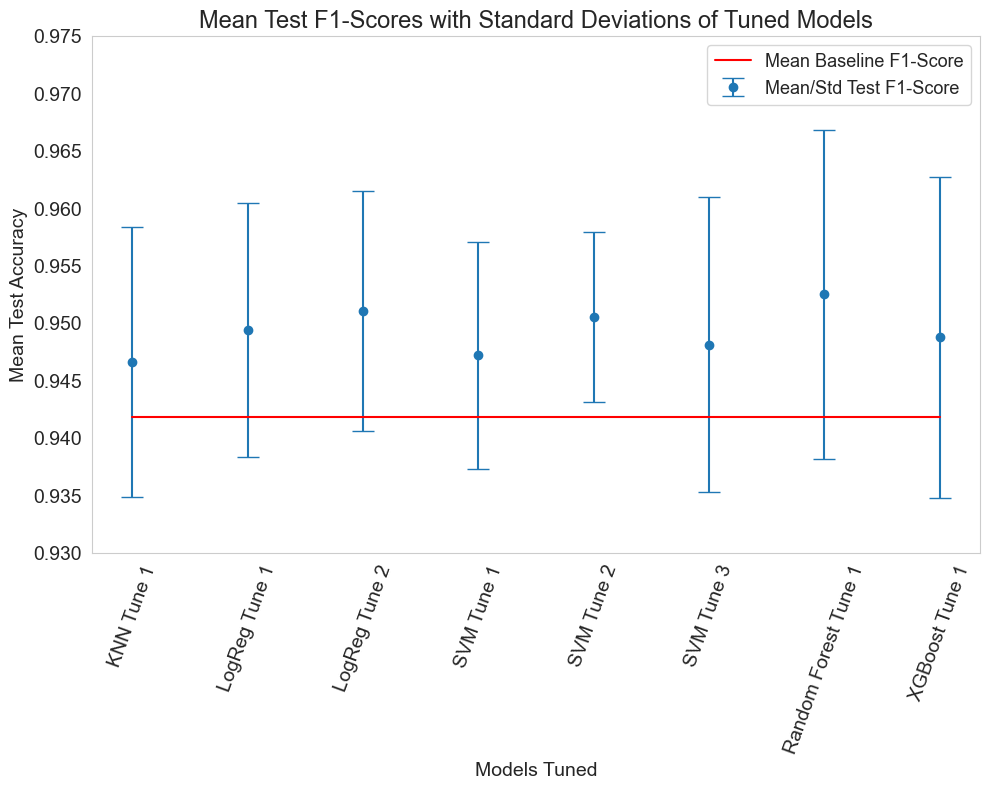

In [76]:
base = 0.941829097482
means = [0.946617, 0.949457, 0.951053, 0.947214, 0.950565, 0.948160, 0.952527, 0.948778]
stds = [0.011775, 0.011064, 0.010449, 0.009894, 0.007410, 0.012846, 0.014333, 0.013943]

plt.figure(figsize=(10,8))
plt.grid()
plt.errorbar(range(8), means, yerr=stds, fmt='o', capsize=8)
plt.plot(range(8), [base]*8, c='red')
plt.xlabel("Models Tuned", fontsize=14)
plt.xticks(range(8), ['KNN Tune 1','LogReg Tune 1','LogReg Tune 2','SVM Tune 1','SVM Tune 2','SVM Tune 3','Random Forest Tune 1','XGBoost Tune 1'], 
           rotation=70,
           fontsize=14)
plt.ylabel("Mean Test Accuracy", fontsize=14)
plt.yticks(np.arange(0.93,0.98,0.005), [f"{i:.3f}" for i in np.arange(0.93,0.98,0.005)], fontsize=14)
plt.title("Mean Test F1-Scores with Standard Deviations of Tuned Models", fontsize=17)
plt.tight_layout()
plt.legend(["Mean Baseline F1-Score", "Mean/Std Test F1-Score"], fontsize=13)
plt.savefig("ACC_STD.png", dpi=1000, bbox_inches='tight')
plt.show()

## (2) Interpretability

### (2.1) Permutation Importance

In [67]:
from sklearn.inspection import permutation_importance

model = RandomForestClassifier()
model.fit(last_X_tr, last_y_tr)
perm_ipt = permutation_importance(model, last_X_te, last_y_te).importances_mean
sorted_index = np.argsort(-perm_ipt)
top_20_names = [list(last_X_te.columns)[i] for i in sorted_index[:20]]
top_20_values = [perm_ipt[i] for i in sorted_index[:20]]

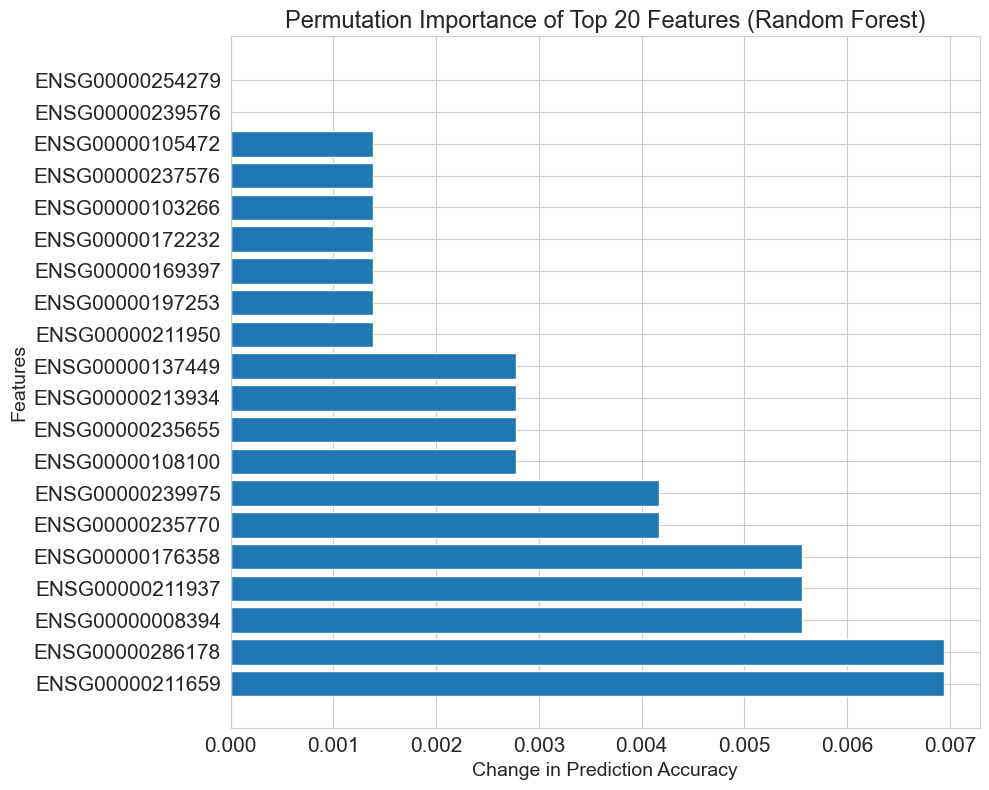

In [69]:
plt.figure(figsize=(10,8))
plt.barh(top_20_names, top_20_values)
plt.xlabel("Change in Prediction Accuracy", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Permutation Importance of Top 20 Features (Random Forest)", fontsize=17)
plt.savefig("PERM.png", dpi=1000, bbox_inches='tight')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

### (2.2) Logistic Regression Coefficients

In [70]:
model = LogisticRegression()
model.fit(last_X_tr, last_y_tr)
coefficients = model.coef_.reshape(last_X_tr.shape[1],)
sorted_index = np.argsort(-np.abs(coefficients))
top_20_names = [list(last_X_te.columns)[i] for i in sorted_index[:20]]
top_20_values = [coefficients[i] for i in sorted_index[:20]]

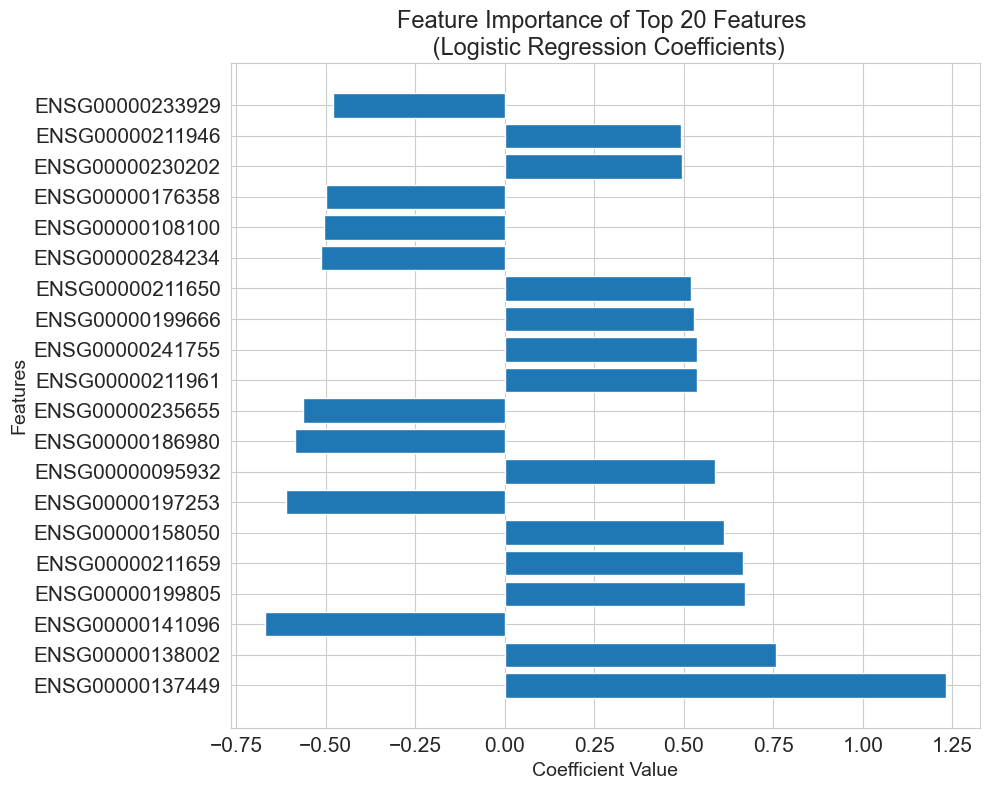

In [71]:
plt.figure(figsize=(10,8))
plt.barh(top_20_names, top_20_values)
plt.xlabel("Coefficient Value", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Feature Importance of Top 20 Features \n (Logistic Regression Coefficients)", fontsize=17)
plt.savefig("COEF.png", dpi=1000, bbox_inches='tight')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

A positive class label = the patient has Covid-19 and a negative class label = the patient does not have Covid-19. <br> 
A feature with negative coefficient means it has a positive impact on predicting a positive class label. <br>
A feature with positive coefficient means it has a negative impact on predicting a negative class label. <br>

### (2.3) Random Forest Feature Importance

In [63]:
model = RandomForestClassifier()
model.fit(last_X_tr, last_y_tr)
rf_import = model.feature_importances_
sorted_index = np.argsort(-rf_import)
top_20_names = [list(last_X_te.columns)[i] for i in sorted_index[:20]]
top_20_values = [rf_import[i] for i in sorted_index[:20]]

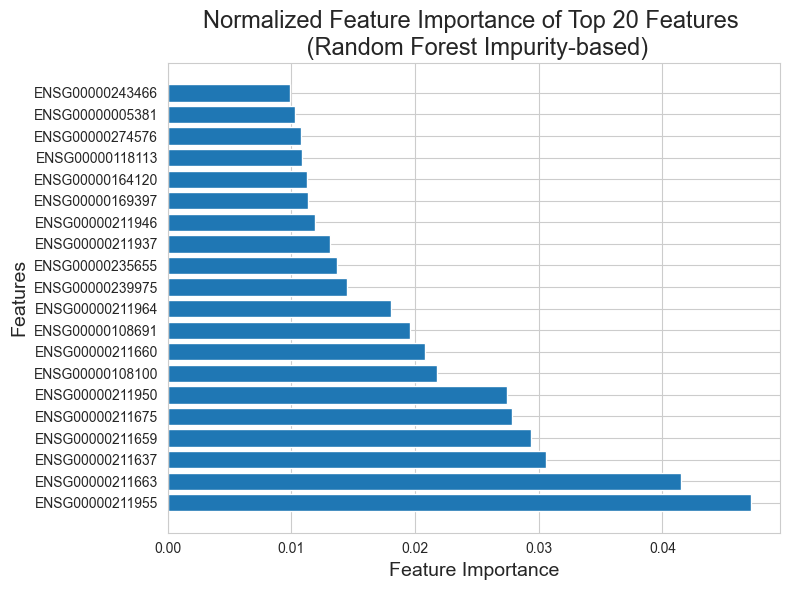

In [64]:
plt.figure(figsize=(8,6))
plt.barh(top_20_names, top_20_values)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Normalized Feature Importance of Top 20 Features \n (Random Forest Impurity-based)", fontsize=17)
plt.savefig("RFIM.png", dpi=1000, bbox_inches='tight')
plt.tight_layout()
plt.show()

Shap Values

Using 144 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


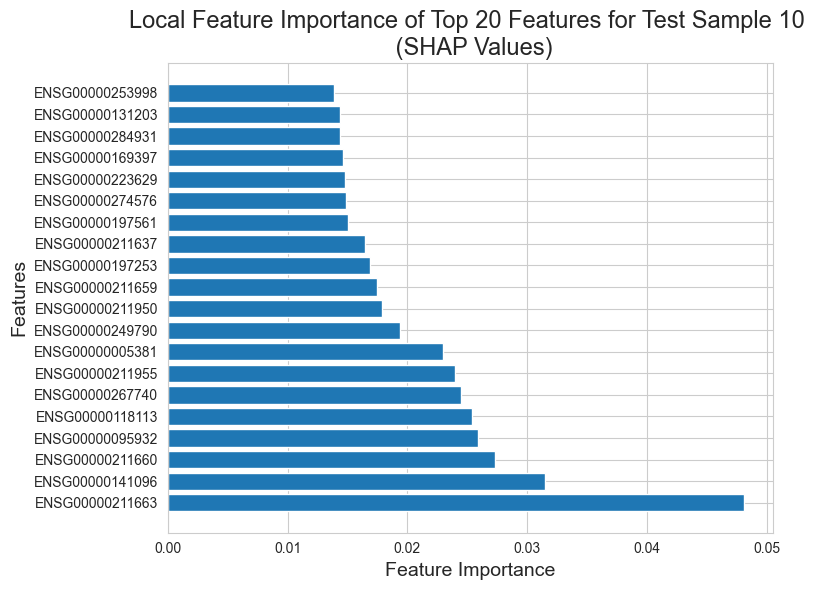

In [66]:
import shap
model = SVC(probability=True)
model.fit(last_X_tr, last_y_tr)
explainer = shap.KernelExplainer(model.decision_function, last_X_te)
sample_indices = 10
shap_values = explainer.shap_values(last_X_te.iloc[sample_indices,:])

sorted_index = np.argsort(-shap_values)
top_20_names = [list(last_X_te.columns)[i] for i in sorted_index[:20]]
top_20_values = [shap_values[i] for i in sorted_index[:20]]

plt.figure(figsize=(8,6))
plt.barh(top_20_names, top_20_values)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Local Feature Importance of Top 20 Features for Test Sample 10 \n (SHAP Values)", fontsize=17)
plt.savefig("SHAP.png", dpi=1000, bbox_inches='tight')
plt.tight_layout()
plt.show()

Other Needs

In [72]:
x = list(ori_TPM.columns)
ori_columns = []
for s in x:
    p, t = s.split('_')
    if p[0] == 'H' or t[1] == 'E':
        continue
    elif len(t) == 2 and t[1] in ['0','3','7']:
        ori_columns.append(s)
    elif len(t) == 3 and t[2] in ['A', 'B']:
        if t[2] == 'A':
            ori_columns.append(f'{p}_D{t[1]}')
print(len(ori_columns))

725


In [74]:
ori_acuity_labels = pd.read_csv("C:\\Users\\xuzef\\Desktop\\pycode\\final_proj\\data\\labels.csv", sep=',', encoding='UTF-8', header=0, index_col=0).iloc[:,1]
sub_acuity = ori_acuity_labels.loc[ori_columns]

ss = list(sub_acuity.index)
cnt_acuity = {1:0,2:0,3:0,4:0,5:0}
patient_counted = []
for a in range(len(sub_acuity)):
    if ss[a].split('_')[0] not in patient_counted:
        patient_counted.append(ss[a].split('_')[0])
        cnt_acuity[sub_acuity[a]] += 1
print(cnt_acuity)

{1: 47, 2: 82, 3: 168, 4: 52, 5: 31}


In [75]:
ss = list(all_TPM.index)
patient_covid = {0:0,1:0}
patient_counted = []
for s in ss:
    c_label = covid_labels.loc[s]
    if s.split('_')[0] not in patient_counted:
        patient_counted.append(s.split('_')[0])
        patient_covid[c_label] += 1
print(patient_covid)

{0: 76, 1: 304}


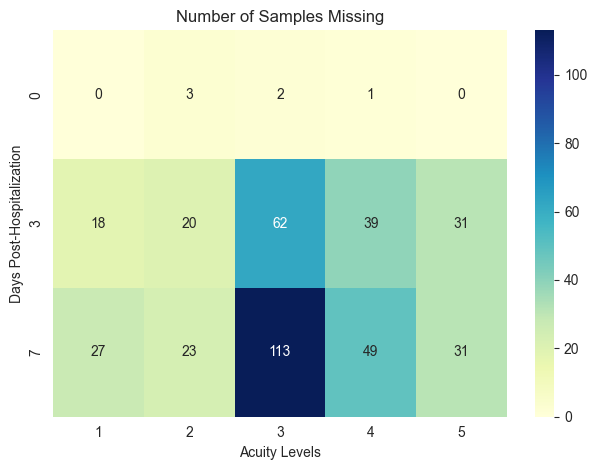

In [76]:
def get_missing(patient, all_samples):
    missing = []
    if f'{patient}_D0' not in all_samples:
        missing.append(0)
    if f'{patient}_D3' not in all_samples:
        missing.append(3)
    if f'{patient}_D7' not in all_samples:
        missing.append(7)
    
    return missing

def get_label(patient, all_samples, acuity):
    if f'{patient}_D0' in all_samples:
        return acuity.loc[f'{p}_D0']
    elif f'{patient}_D3' in all_samples:
        return acuity.loc[f'{p}_D3']
    elif f'{patient}_D7' in all_samples:
        return acuity.loc[f'{p}_D7']
    else:
        return -1

all_sample_names = list(all_TPM.index)
missing_samples = {}
for p in range(1, 387):         # ID ranges from 1 to 386
    miss = get_missing(p, all_sample_names)
    if len(miss) != 3:
        missing_samples[p] = miss

acuity_map = {}
for p in range(1, 387):
    l = get_label(p, all_sample_names, acuity_labels)
    if l != -1:
        acuity_map[p] = l

missing_map_acuity = {1:{0:0, 3:0, 7:0}, 2:{0:0, 3:0, 7:0}, 3:{0:0, 3:0, 7:0}, 4:{0:0, 3:0, 7:0}, 5:{0:0, 3:0, 7:0}}
acuity_level_count = {1:0, 2:0, 3:0, 4:0, 5:0}
for p in list(missing_samples.keys()):
    acuity_level = acuity_map[p]
    for s in missing_samples[p]:
        missing_map_acuity[acuity_level][s] += 1

df = pd.DataFrame(missing_map_acuity)
import seaborn as sns
sns.heatmap(df, annot=df, fmt='g', cmap='YlGnBu')
plt.xlabel("Acuity Levels")
plt.ylabel("Days Post-Hospitalization")
plt.title("Number of Samples Missing")
plt.savefig("MT1.png", dpi=1000, bbox_inches='tight')
plt.tight_layout()
plt.show()